In [1]:
from codebase import MultiTaskModel, IDRiDSegmentation, IDRiDClassification, get_seg_transforms

import json
import torch
import random
import numpy as np
import matplotlib.pyplot as plt

/data2/home/shishirm/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
cfg = {
    "batch_size": 1,
    "size": [712, 1072],
    "norm_mean": [0.485, 0.456, 0.406],
    "norm_std": [0.229, 0.224, 0.225],

    "backbone": "resnet50",
    "task_specs": {
        "classification_1": 5,
        "classification_2": 3,
        "segmentation_MA": 1,
        "segmentation_HE": 1,
        "segmentation_EX": 1,
        "segmentation_SE": 1,
        "segmentation_OD": 1,
    },
    "num_experts": 3,

    "train_path": "./data/B. Disease Grading/2. Groundtruths/a. IDRiD_Disease Grading_Training Labels.csv",
    "test_path": "./data/B. Disease Grading/2. Groundtruths/b. IDRiD_Disease Grading_Testing Labels.csv",
}

In [3]:
model = MultiTaskModel(
    backbone=cfg["backbone"],
    task_specs=cfg["task_specs"],
    num_experts=cfg["num_experts"]
)

num_parameters = sum(p.numel() for p in model.parameters())
print("Number of parameters =", num_parameters)

checkpoint = torch.load("./saved/mlt_100.pth", map_location="cpu", weights_only=True)
model.load_state_dict(checkpoint)
model.eval()

Number of parameters = 42372668


MultiTaskModel(
  (resnet): ResNet(
    (layer_0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (layer_1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (do

In [4]:
transform_train, transform_val_test = get_seg_transforms(cfg["size"], cfg["norm_mean"], cfg["norm_std"])
test_seg_set = IDRiDSegmentation(root="./data/A. Segmentation/", mode="eval", transform=transform_val_test)
test_classi_set = IDRiDClassification(path=cfg["test_path"], size=cfg["size"], normalize_mean=cfg["norm_mean"], normalize_std=cfg["norm_std"], mode="eval")

seg_len = len(test_seg_set)
classi_len = len(test_classi_set)

In [5]:
def denormalize(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    mean = torch.tensor(mean).view(-1, 1, 1)
    std = torch.tensor(std).view(-1, 1, 1)
    return image * std + mean

In [ ]:
def visualize_model_output(image, pred_masks, pred_label_0, pred_label_1, gt_masks, gt_label_0, gt_label_1):
    mask_labels = {
        0: 'Microaneurysms',
        1: 'Haemorrhages',
        2: 'Hard Exudates',
        3: 'Soft Exudates',
        4: 'Optic Disc'
    }

    image = image.permute(1, 2, 0).cpu().numpy()    # [H, W, 3]
    pred_masks = [mask.cpu().numpy() for mask in pred_masks]  # 5x [H, W]
    gt_masks = [mask.cpu().numpy() for mask in gt_masks]  # 5x [H, W]
    
    image = (image * 255).astype(np.uint8)
    
    id_2_color = json.load(open("./codebase/trainid_to_color.json", 'r'))
    id_2_color = {int(k): v for k, v in id_2_color.items()}
    
    fig, axes = plt.subplots(3, 4, figsize=(24, 16))
    axes = axes.flatten()

    axes[0].imshow(image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].axis('off')
    axes[1].text(
        0.5, 0.7,
        f"Ground Truth Labels:\nRG {gt_label_0}\nMER {gt_label_1}",
        fontsize=12,
        ha='center'
    )
    axes[1].text(
        0.5, 0.3,
        f"Predicted Labels:\nRG {pred_label_0}\nMER {pred_label_1}",
        fontsize=12,
        ha='center'
    )
    
    # Display each mask overlaid on the image
    for i in range(5):
        overlay_1 = image.copy()
        overlay_2 = image.copy()
        gt_mask = gt_masks[i]
        pred_mask = pred_masks[i]
        
        overlay_1 = overlay_1.astype(np.float32)
        overlay_1[gt_mask == 1] = 0.3 * overlay_1[gt_mask == 1] + 0.7 * np.array(id_2_color[i])

        overlay_2 = overlay_2.astype(np.float32)
        overlay_2[pred_mask == 1] = 0.3 * overlay_2[pred_mask == 1] + 0.7 * np.array(id_2_color[i])
        
        axes[2 * i + 2].imshow(overlay_1.astype(np.uint8))
        axes[2 * i + 2].set_title("Ground Truth: "+mask_labels[i])
        axes[2 * i + 2].axis('off')

        axes[2 * i + 3].imshow(overlay_2.astype(np.uint8))
        axes[2 * i + 3].set_title("Model prediction: "+mask_labels[i])
        axes[2 * i + 3].axis('off')
    
    plt.tight_layout()
    plt.show()

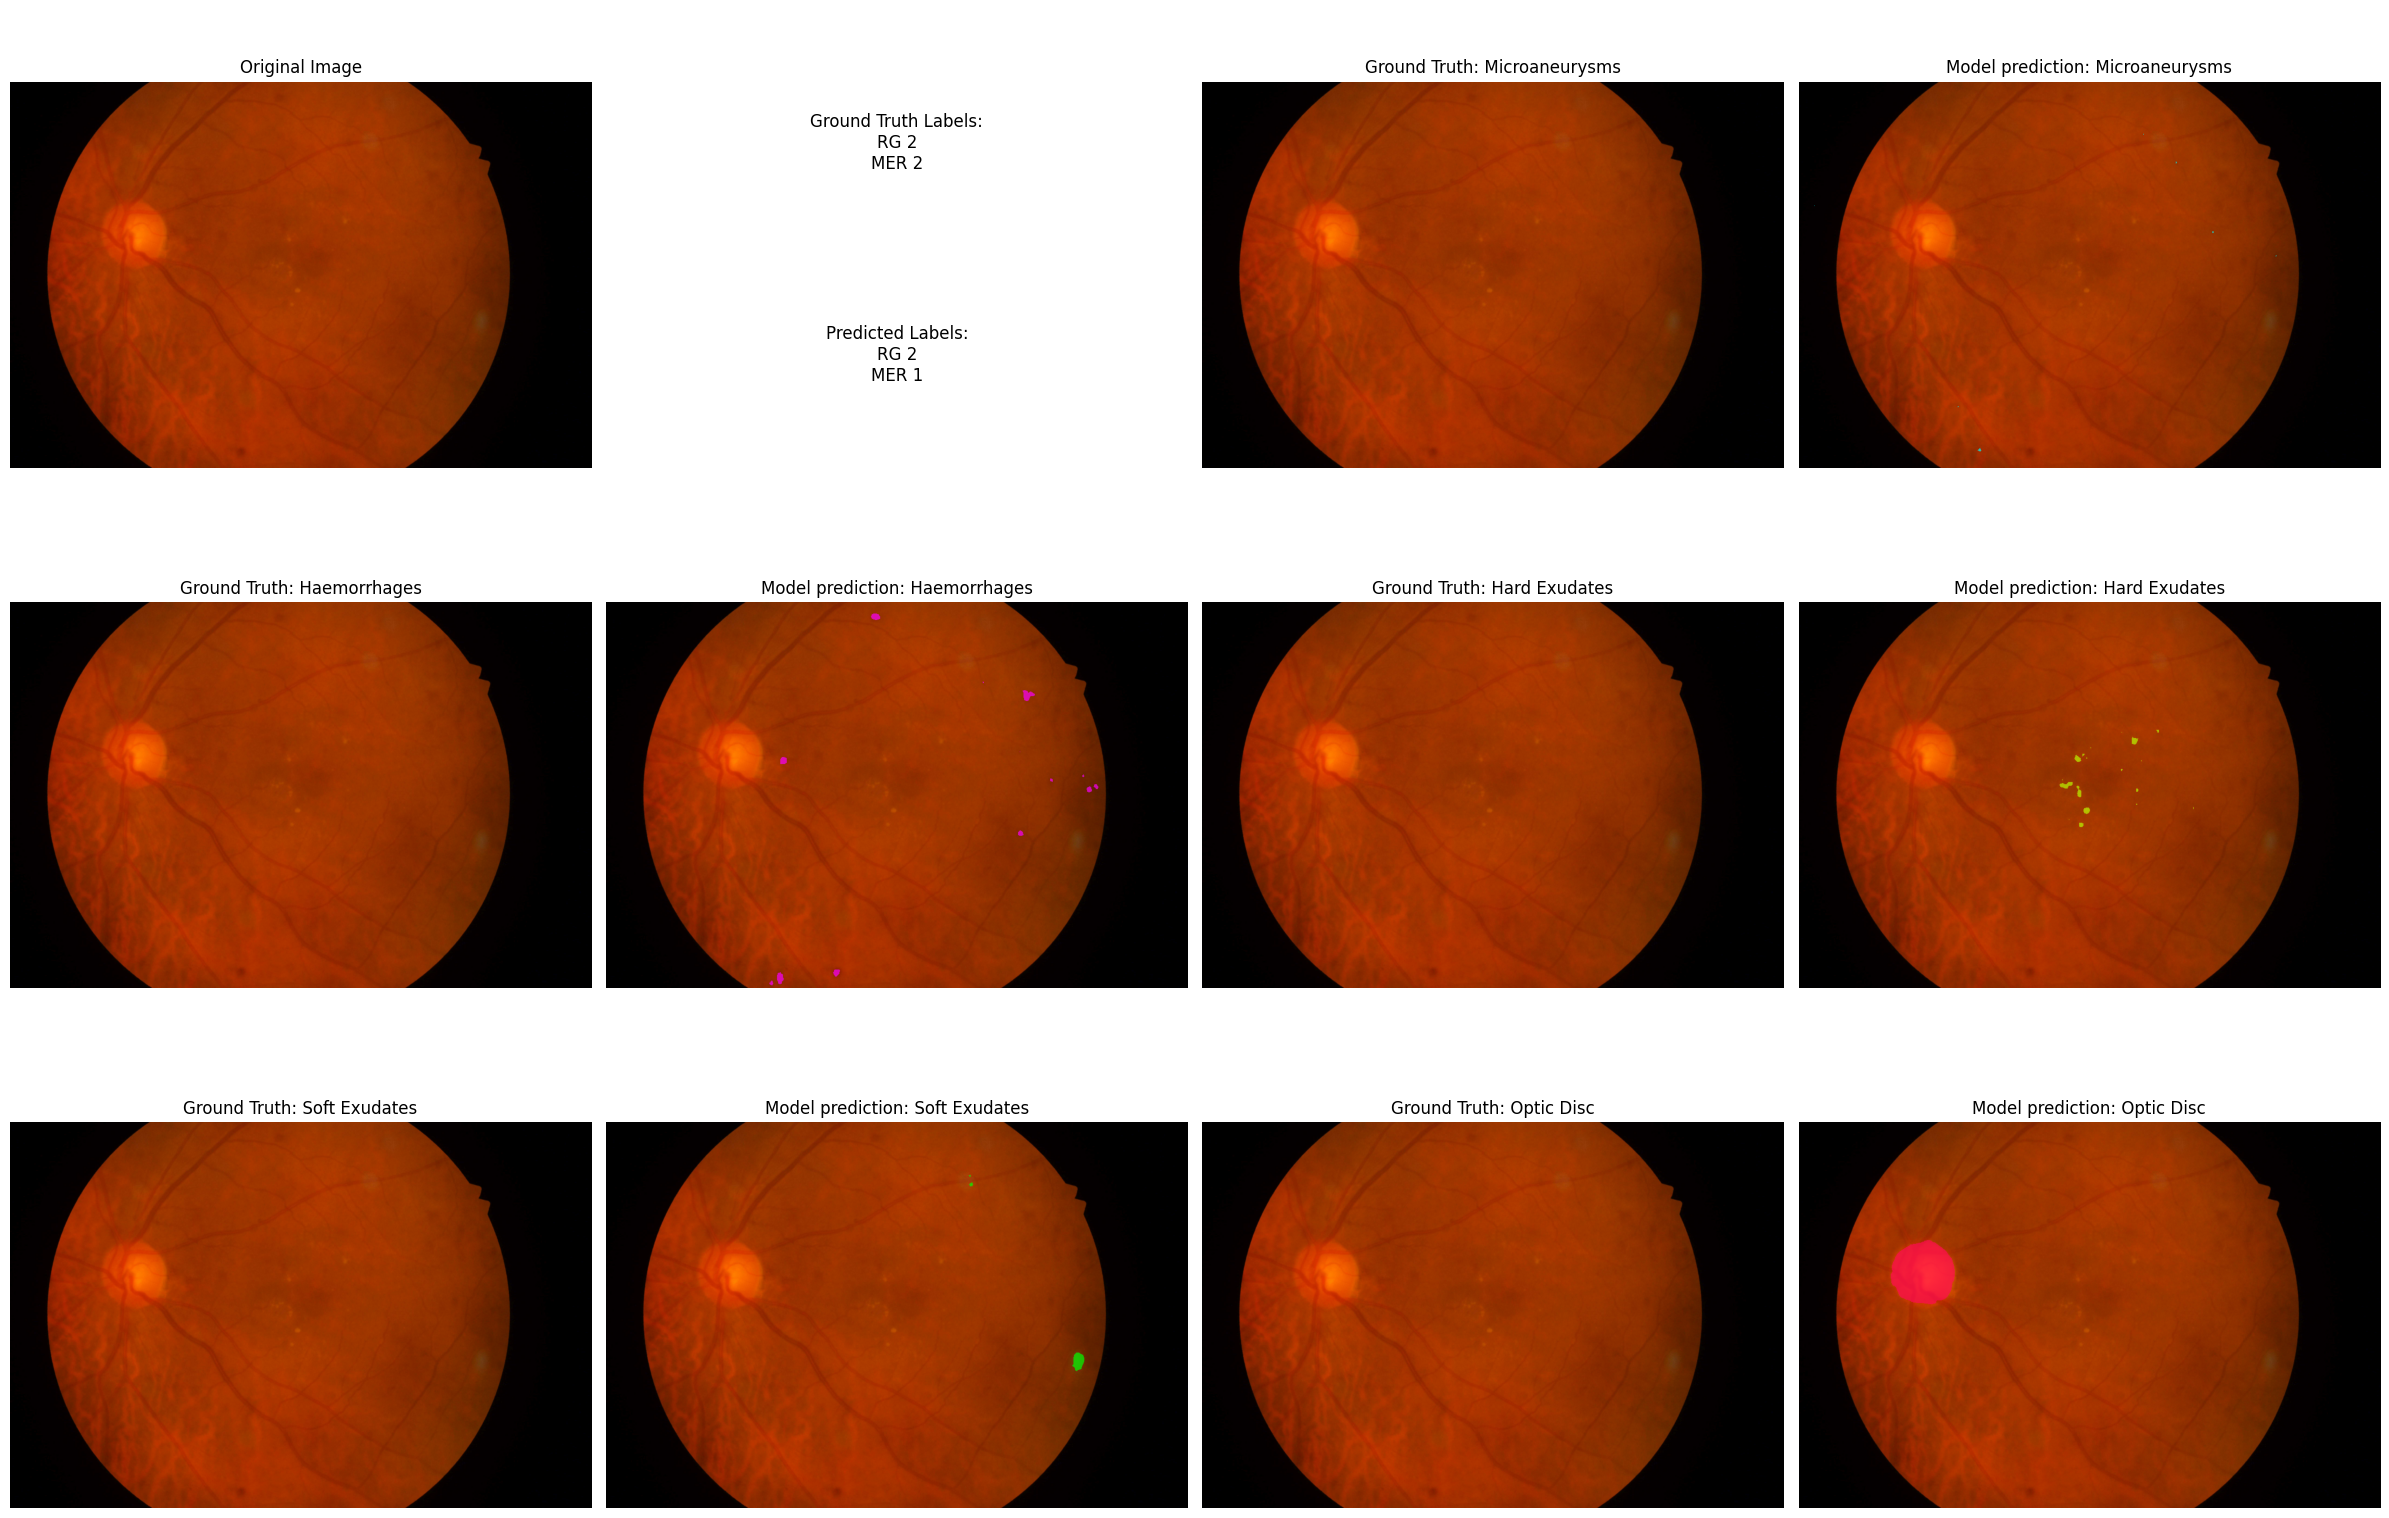

In [30]:
idx = random.randint(0, classi_len - 1)
image, target = test_classi_set.__getitem__(idx)

gt_label_0, gt_label_1 = target["classification_1"].item(), target["classification_2"].item()
gt_masks = [torch.zeros((712, 1072)) for i in range(5)]

outputs, gate_scores = model(image.unsqueeze(0))
pred_masks = []
pred_label_0 = outputs["classification_1_logits"].argmax(dim=1).item()
pred_label_1 = outputs["classification_2_logits"].argmax(dim=1).item()
for k, v in outputs.items():
    if 'segmentation' in k:
        probs = v[0, 0].sigmoid()
        mask = torch.zeros_like(probs)
        mask[probs > 0.5] = 1
        pred_masks.append(mask)

visualize_model_output(denormalize(image), pred_masks, pred_label_0, pred_label_1, gt_masks, gt_label_0, gt_label_1)

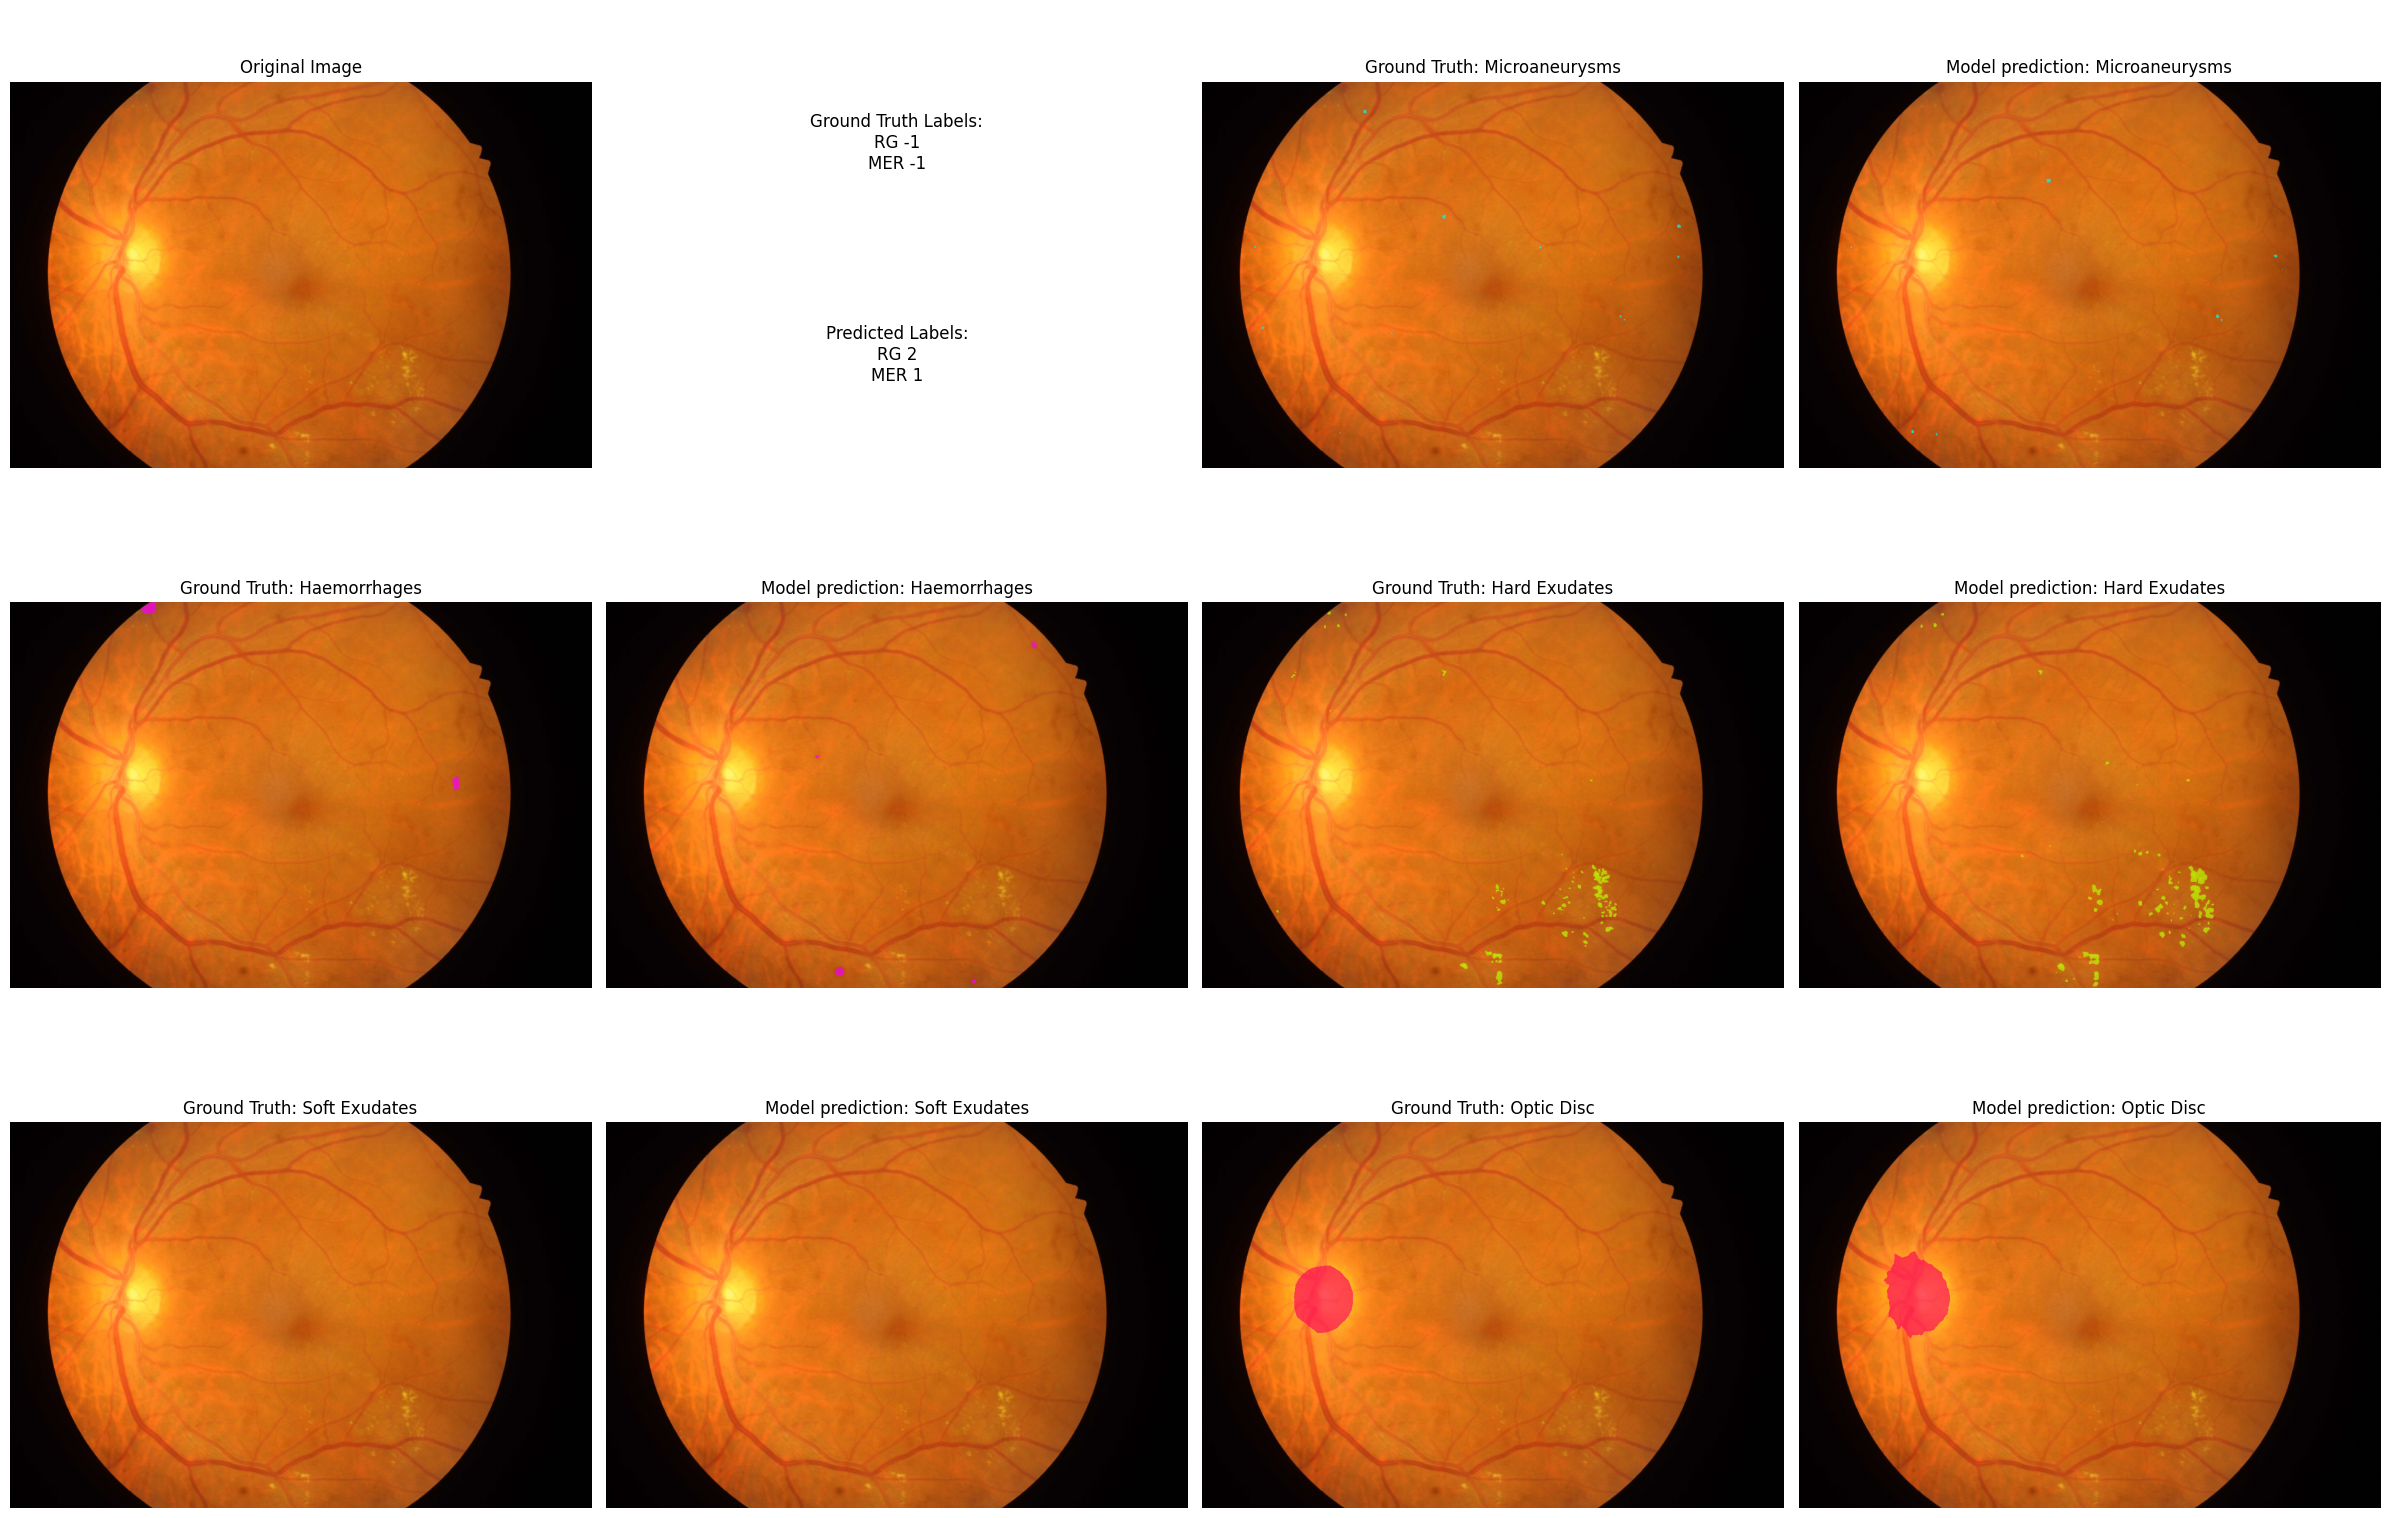

In [31]:
idx = random.randint(0, seg_len - 1)
image, target = test_seg_set.__getitem__(idx)
gt_masks = []
gt_label_0, gt_label_1 = -1, -1
for k, v in target.items():
    gt_masks.append(v[0])

outputs, gate_scores = model(image.unsqueeze(0))
pred_masks = []
pred_label_0 = outputs["classification_1_logits"].argmax(dim=1).item()
pred_label_1 = outputs["classification_2_logits"].argmax(dim=1).item()
for k, v in outputs.items():
    if 'segmentation' in k:
        probs = v[0, 0].sigmoid()
        mask = torch.zeros_like(probs)
        mask[probs > 0.5] = 1
        pred_masks.append(mask)

visualize_model_output(denormalize(image), pred_masks, pred_label_0, pred_label_1, gt_masks, gt_label_0, gt_label_1)